In [1]:
import numpy as np
import tensorflow as tf
import gym
from ppo import PPO
from recorder import Recorder
from logRewards import DataLogger
import warnings
warnings.filterwarnings('ignore') #ignora warnings
seed=42

2025-01-13 17:18:56.518495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736785136.533564  111537 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736785136.537939  111537 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 17:18:56.553541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

tf.random.set_seed(seed)
np.random.seed(seed)


# Configurazione ed esecuzione
#Lista di giochi a disposizione di Procgen:
""" 
    coinrun, starpilot
"""
seed=42
gameName="starpilot" 
env = gym.make('procgen:procgen-'+gameName+'-v0',distribution_mode='easy',start_level=seed,rand_seed=seed, num_levels=200, use_backgrounds=False)
recorder=Recorder(gameName)
dataLogger=DataLogger(gameName)
ppo=PPO(env,weightsPath=None,recorder=recorder,dataLogger=dataLogger,gameName=gameName)

I0000 00:00:1736785140.165483  111537 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2784 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


ACTOR CRITIC LOADED


Model: "actor_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_dense4 (Dense)        │ (1, 15)                │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,095 (539.44 KB)

 Trainable params: 46,031 (179.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,064 (359.63 KB)

Model: "critic_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_dense4 (Dense)       │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,677 (518.27 KB)

 Trainable params: 44,225 (172.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,452 (345.52 KB)

In [ ]:


for epoch in range(ppo.nEpochs):                                            # Main training loop for n epochs
        print(f"Epoch: {epoch} | Beginning rollout")                     
        obs ,actions ,logp , returns, advs = ppo.rollout()                                  # Get Rollout and infos
        #Check if batches contains nan or inf values
        try:
                tf.debugging.check_numerics(tf.cast(obs, tf.float32), "obs_batch has nan or inf values")
                tf.debugging.check_numerics(tf.cast(actions, tf.float32), "actions_batch has nan or inf values")
                tf.debugging.check_numerics(logp, "logp_t_batch has nan or inf values")
                tf.debugging.check_numerics(advs, "advs_batch has nan or inf values")
                tf.debugging.check_numerics(returns, "returns_batch has nan or inf values")
        except:
                print("OBS:")
                print(obs)
                print("logp BATCH HAS NAN OR INF VALUES")
                print(logp)
                print("ADVS BATCH HAS NAN OR INF VALUES")
                print(advs)
                print("returns BATCH HAS NAN OR INF VALUES")
                print(returns)
                break
                
        print(f"Epoch: {epoch} | Rollout completed")                     
        print(obs.shape,actions.shape,logp.shape,returns.shape,advs.shape)
        total_loss = ppo.train(obs,actions,advs,returns,logp)                                         # Push rollout in ppo and update policy accordingly
        print(f"Epoch: {epoch} | Loss: {total_loss}")                     # Print loss for each epoch
        ppo.save_model(epoch=epoch)
        ppo.update_hyperparams(epoch=epoch)
        if epoch % 5 ==0:
                ppo.evaluate_model()
        del obs ,actions ,logp , returns, advs
        


I0000 00:00:1736785141.064163  111537 cuda_dnn.cc:529] Loaded cuDNN version 90300


Reward rollout:  108.0
Epoch: 0 | Rollout completed
(4096, 64, 64, 3) (4096,) (4096,) (4096,) (4096,)
Early stopping at step 1 due to reaching max kl.
Epoch: 0 | Loss: 0.21809951961040497
pathActor: ./weights/starpilot/actor.keras
pathCritic: ./weights/starpilot/critic.keras
Model saved at epoch:  0
Episode reward: 1.0 Episode steps: 29
Episode reward: 0.0 Episode steps: 48
Episode reward: 0.0 Episode steps: 68
Episode reward: 0.0 Episode steps: 73
Episode reward: 1.0 Episode steps: 63
Episode reward: 0.0 Episode steps: 88
Episode reward: 3.0 Episode steps: 51
Episode reward: 0.0 Episode steps: 72
Episode reward: 0.0 Episode steps: 68
Episode reward: 0.0 Episode steps: 54
Average Reward: 0.50
Min Reward: 0.00
Max Reward: 3.00
Cumulative Reward: 5.00
Average steps per episode:  61.4
Total Steps:  614
Reward rollout:  132.0
Epoch: 1 | Rollout completed
(4096, 64, 64, 3) (4096,) (4096,) (4096,) (4096,)
Early stopping at step 3 due to reaching max kl.
Epoch: 1 | Loss: 0.25856178998947144
R

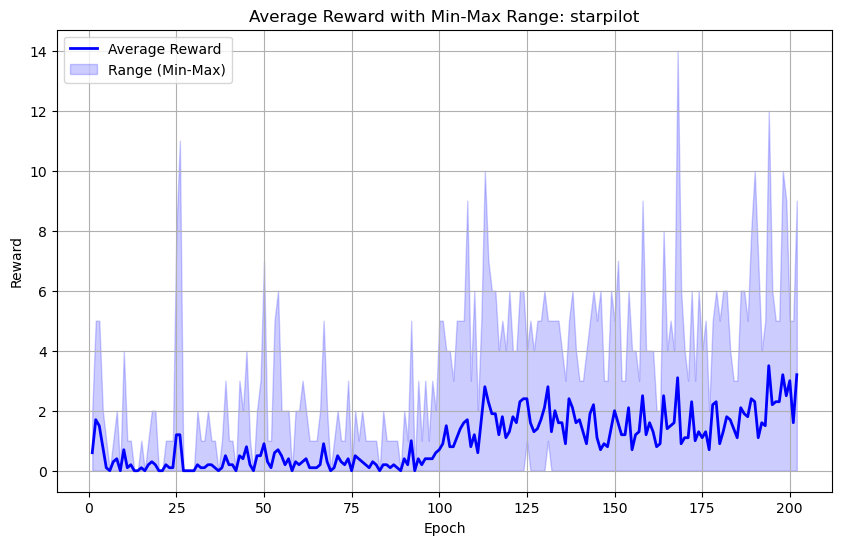

In [4]:
#Show graphs

dataLogger.showGraphAverageReward()

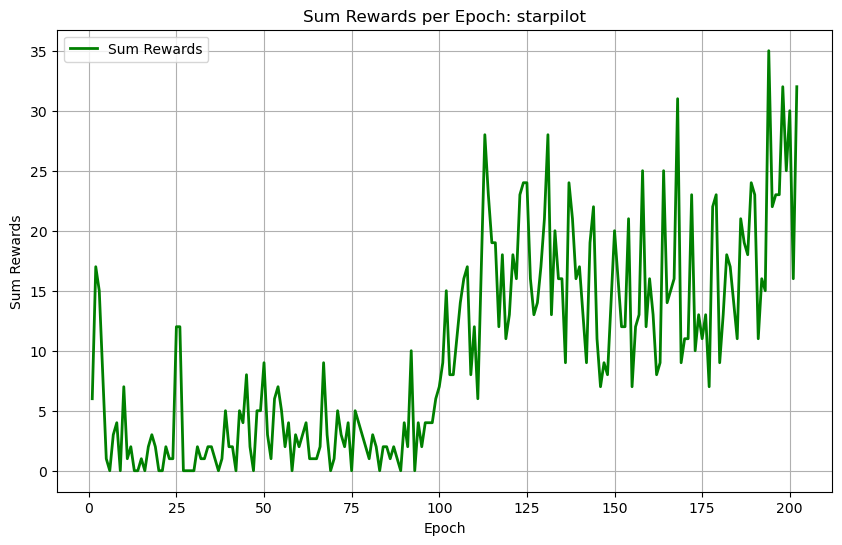

In [ ]:

dataLogger.showGraphCumulativeReward()

In [7]:

seed=1
tf.random.set_seed(seed)
np.random.seed(seed)
env = gym.make('procgen:procgen-'+gameName+'-v0',distribution_mode='easy',start_level=seed,rand_seed=seed, num_levels=200, use_backgrounds=False)
ppo_weighted=PPO(env,weightsPath=None,recorder=None,dataLogger=None,gameName=gameName,training=False)

weighted_result=ppo_weighted.evaluate_model(100)
del ppo_weighted


ACTOR CRITIC LOADED


Model: "actor_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_dense4 (Dense)        │ (1, 15)                │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,095 (539.44 KB)

 Trainable params: 46,031 (179.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,064 (359.63 KB)

Model: "critic_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_dense4 (Dense)       │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,677 (518.27 KB)

 Trainable params: 44,225 (172.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,452 (345.52 KB)

Episode reward: 0.0 Episode steps: 73
Episode reward: 1.0 Episode steps: 81
Episode reward: 1.0 Episode steps: 76
Episode reward: 4.0 Episode steps: 162
Episode reward: 0.0 Episode steps: 65
Episode reward: 1.0 Episode steps: 54
Episode reward: 0.0 Episode steps: 78
Episode reward: 1.0 Episode steps: 71
Episode reward: 2.0 Episode steps: 59
Episode reward: 0.0 Episode steps: 78


KeyboardInterrupt: 

In [8]:
ppo_not_weighted=PPO(env,weightsPath="..",recorder=None,dataLogger=None,gameName=gameName,training=False)

result=ppo_not_weighted.evaluate_model(100,False)




--------- EXCEPTION :
File not found: filepath=../actor.keras. Please ensure the file is an accessible `.keras` zip file.
Errore nel caricamento dei pesi


Model: "actor_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_dense4 (Dense)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,096 (172.25 KB)

 Trainable params: 44,096 (172.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "critic_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_dense4 (Dense)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,096 (172.25 KB)

 Trainable params: 44,096 (172.25 KB)

 Non-trainable params: 0 (0.00 B)

Episode reward: 7.0 Episode steps: 71
Episode reward: 2.0 Episode steps: 116
Episode reward: 2.0 Episode steps: 99
Episode reward: 2.0 Episode steps: 91
Episode reward: 1.0 Episode steps: 64
Episode reward: 2.0 Episode steps: 52
Episode reward: 5.0 Episode steps: 102
Episode reward: 1.0 Episode steps: 94
Episode reward: 2.0 Episode steps: 76
Episode reward: 2.0 Episode steps: 66
Episode reward: 0.0 Episode steps: 72
Episode reward: 0.0 Episode steps: 78
Episode reward: 1.0 Episode steps: 60
Episode reward: 0.0 Episode steps: 57
Episode reward: 2.0 Episode steps: 73
Episode reward: 2.0 Episode steps: 75
Episode reward: 0.0 Episode steps: 57
Episode reward: 2.0 Episode steps: 86
Episode reward: 2.0 Episode steps: 87
Episode reward: 1.0 Episode steps: 49
Episode reward: 0.0 Episode steps: 59
Episode reward: 2.0 Episode steps: 126
Episode reward: 4.0 Episode steps: 63
Episode reward: 1.0 Episode steps: 104
Episode reward: 1.0 Episode steps: 80
Episode reward: 1.0 Episode steps: 78
Episode 

In [6]:
print("Weighted model result: ",weighted_result)
print("Not weighted model result: ",result)

Weighted model result:  (7.0, 0.0, 10.0, 700.0)
Not weighted model result:  (3.9, 0.0, 10.0, 390.0)
